# Import Dependencies

In [75]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

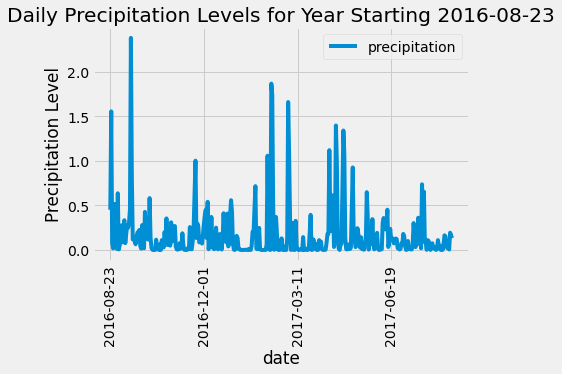

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database

end_date = session.query(measurement.date).\
            order_by(measurement.date.desc()).first()

start_date = (dt.datetime.strptime(end_date[0],'%Y-%m-%d') - dt.timedelta(days=365)).strftime('%Y-%m-%d')

# Perform a query to retrieve the data and precipitation scores
measurements = (measurement.date, func.avg(measurement.prcp))

precipitation = session.query(*measurements).\
            group_by(measurement.date).\
            filter(measurement.date >= start_date).all()

# # Save the query results as a Pandas DataFrame and set the index to the date column

weather_df = pd.DataFrame(precipitation,columns=['date','precipitation'])
weather_df.set_index('date', inplace=True)
weather_df = weather_df.sort_index()
weather_df =weather_df.fillna(0)

#Use Pandas Plotting with Matplotlib to plot the data
ax = weather_df.plot(rot=90)
ax.set_title(f"Daily Precipitation Levels for Year Starting {start_date}")
ax.set_ylabel("Precipitation Level")
plt.savefig("Images/Daily_Precip_Level.png")

In [11]:
# Use Pandas to calcualte the summary statistics for the precipitation data
weather_df.describe()

,precipitation
count,366.000000
mean,0.170757
std,0.295683
min,0.000000
25%,0.008571
50%,0.070000
75%,0.191667
max,2.380000


# Station Analysis

In [12]:
# Design a query to show how many stations are available in this dataset?
stations = session.query(func.count(station.id)).all()
stations

[(9)]

In [13]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

active_stations = session.query(measurement.station, func.count(measurement.station)).\
                  group_by(measurement.station).\
                  order_by(func.count(measurement.station).desc()).all()
active_stations


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [14]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
station_temps = session.query(func.min(measurement.tobs),func.min(measurement.tobs), func.avg(measurement.tobs)).\
                filter(measurement.station == 'USC00519281').all()
station_temps
              

[(54.0, 54.0, 71.66378066378067)]

In [15]:
# Choose the station with the highest number of temperature observations.
most_active =  session.query(measurement.station).group_by(measurement.station).\
               order_by(func.count(measurement.date).desc()).first()
most_active[0]

'USC00519281'

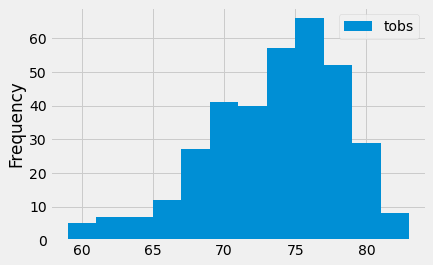

In [16]:
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
USC00519281 =  session.query(measurement.date,measurement.tobs).\
               filter(measurement.station == 'USC00519281').\
               filter(measurement.date > start_date).all()

USC00519281_df= pd.DataFrame(USC00519281)
USC00519281_df.plot(kind="hist",bins=12);

# Bonus Climate App NEED TO DO

In [17]:
# Now that you have completed your initial analysis, design a Flask API based on the queries that you have just developed.

# * Use Flask to create your routes.

In [18]:
# ## Routes

# * `/`

#   * Home page.

#   * List all routes that are available.

# * `/api/v1.0/precipitation`

#   * Convert the query results to a dictionary using `date` as the key and `prcp` as the value.

#   * Return the JSON representation of your dictionary.

# * `/api/v1.0/stations`

#   * Return a JSON list of stations from the dataset.

# * `/api/v1.0/tobs`
#   * Query the dates and temperature observations of the most active station for the last year of data.
  
#   * Return a JSON list of temperature observations (TOBS) for the previous year.

# * `/api/v1.0/<start>` and `/api/v1.0/<start>/<end>`

#   * Return a JSON list of the minimum temperature, the average temperature, and the max temperature for a given start or start-end range.

#   * When given the start only, calculate `TMIN`, `TAVG`, and `TMAX` for all dates greater than and equal to the start date.

#   * When given the start and the end date, calculate the `TMIN`, `TAVG`, and `TMAX` for dates between the start and end date inclusive.

# ## Hints

# * You will need to join the station and measurement tables for some of the queries.

# * Use Flask `jsonify` to convert your API data into a valid JSON response object.


# Bonus Tempurature Analysis I

In [19]:
# * Hawaii is reputed to enjoy mild weather all year. Is there a meaningful difference between the temperature in, for example, June and December?

# * You may either use SQLAlchemy or pandas's `read_csv()` to perform this portion.

# * Identify the average temperature in June at all stations across all available years in the dataset. Do the same for December temperature.

# * Use the t-test to determine whether the difference in the means, if any, is statistically significant. Will you use a paired t-test, or an unpaired t-test? Why?

In [20]:
# return data for June and December
june_data = session.query(measurement.date, measurement.tobs).filter(func.strftime("%m",measurement.date) == '06').all()
dec_data = session.query(measurement.date, measurement.tobs).filter(func.strftime("%m",measurement.date) == '12').all()

# Create Singluar data frame
june_df = pd.DataFrame(june_data,columns=["Date","Temperature"])
dec_df = pd.DataFrame(dec_data,columns=["Date","Temperature"])

#rename Columns
june_df["Month"] = "June"
dec_df["Month"] = "December"

#Comcat data
temp_df = pd.concat([june_df,dec_df], ignore_index=True)

# calculate the average for both June and December
avg_temp = temp_df.groupby("Month").mean()
avg_temp

,Temperature
Month,
December,71.041529
June,74.944118


Ttest_indResult(statistic=31.60372399000329, pvalue=3.9025129038616655e-191)

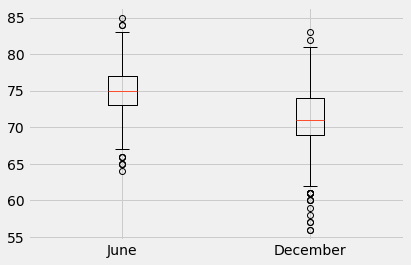

In [21]:
# * Use the t-test to determine whether the difference in the means, if any,
#is statistically significant. 
#Will you use a paired t-test, or an unpaired t-test? Why?

box_data = [june_df["Temperature"],dec_df["Temperature"]]
plt.boxplot(box_data,labels=['June', 'December']);
stats.ttest_ind(june_df["Temperature"], dec_df["Temperature"])

The plot indicates that there is a meaningful temperature 
difference between the months of June and Decmeber. 

Since the p-value is less than 0.05, (3.90) we can reject 
the null hypothesis thus conclude=ing that the difference 
in means is statistically significant.

# Bonus Tempurature Analysis II

In [22]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(measurement.tobs), func.avg(measurement.tobs), func.max(measurement.tobs)).\
        filter(measurement.date >= start_date).filter(measurement.date <= end_date).all()

In [23]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

#set trip dates
trip_start = '2014-04-17'
trip_end = '2014-04-21'

#previous year calcs
last_start_date= (dt.datetime.strptime(trip_start,'%Y-%m-%d') - dt.timedelta(days=365)).strftime('%Y-%m-%d')
last_end_date= (dt.datetime.strptime(trip_end,'%Y-%m-%d') - dt.timedelta(days=365)).strftime('%Y-%m-%d')

vaca_temps = calc_temps(last_start_date,last_end_date)
vaca_temps

[(65.0, 72.8108108108108, 79.0)]

In [24]:
# create the dataframe
vaca_df = pd.DataFrame(vaca_temps, columns=['tmin', 'tavg', 'tmax'])

Text(0.5, 1.0, 'Trip Avg Temp')

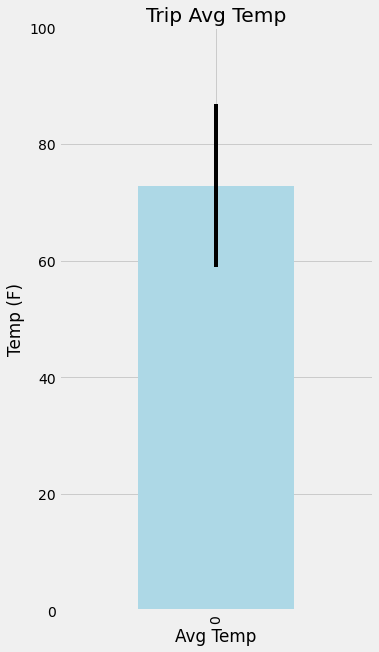

In [25]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

plt.figure(figsize=(5,10))
ax=vaca_df["tavg"].plot.bar(yerr=(vaca_df["tmax"]-vaca_df["tmin"]), color="lightblue")
plt.ylim(0,100)
plt.xlabel("Avg Temp")
plt.ylabel("Temp (F)")
plt.title("Trip Avg Temp")

# Rainfall Analysis NEED TO FINISH

In [26]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
sel = [func.count(measurement.prcp),measurement.station, station.name, station.latitude, station.longitude,station.elevation]
rainfall=session.query(*sel).filter(measurement.station==station.station).\
    group_by(measurement.station).\
    filter(measurement.date >= last_start_date).filter(measurement.date <= last_end_date).\
    order_by(func.count(measurement.prcp).desc()).all()
for r in rainfall:
    print(r)


(5, 'USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5)
(5, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0)
(5, 'USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9)
(5, 'USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4)
(5, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6)
(5, 'USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9)
(4, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0)
(2, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9)


In [27]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(measurement.tobs), func.avg(measurement.tobs), func.max(measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [74]:
#Query for dates
june_raw = session.query(measurement.date).\
            filter(func.strftime("%m",measurement.date) == '06').all()
dec_raw = session.query(measurement.date).\
            filter(func.strftime("%m",measurement.date) == '12').all()


# Daily Norms NEED TO DO

In [31]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip (from Above)
trip_start = dt.datetime.strptime(trip_start,'%Y-%m-%d') 
trip_end = dt.datetime.strptime(trip_end,'%Y-%m-%d') 

# Use the start and end date to create a range of dates
# Stip off the year and save a list of %m-%d strings

diff = trip_end - trip_start
trip_normals = []

for i in range(diff.days + 1):
    day = trip_start + dt.timedelta(days=i)
   
    # Strip off the year and save a list of %m-%d strings
    month_day = dt.datetime.strftime(day,'%m-%d')
    trip_normals.append(month_day)

# Loop through the list of %m-%d strings and calculate the normals for each date

trip_normal_list = []
for day in trip_normals:
    trip_normal_list.append(daily_normals(day)[0])
    
trip_normal_list


[(65.0, 71.93103448275862, 77.0),
 (67.0, 72.49152542372882, 77.0),
 (65.0, 72.42105263157895, 83.0),
 (64.0, 72.73684210526316, 80.0),
 (66.0, 72.32142857142857, 78.0)]

In [34]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
trip_normals_df = pd.DataFrame(trip_normal_list,columns=["tmin","tavg","tmax"],index=[trip_normals])
trip_normals_df.index = trip_normals_df.index.get_level_values(0)
trip_normals_df


,tmin,tavg,tmax
04-17,65.0,71.931034,77.0
04-18,67.0,72.491525,77.0
04-19,65.0,72.421053,83.0
04-20,64.0,72.736842,80.0
04-21,66.0,72.321429,78.0


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
